# Optimization Project-2

## Group 3

### Defining a function to find the optimal subset of stocks to form a portfolio that would best replicate the Index fund.

In [8]:
import pandas as pd
from datetime import datetime
import numpy as np
import gurobipy as gp
from gurobipy import GRB

def small_portfolio(train_csv,test_csv,m):
    
    df = pd.read_csv(train_csv)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df.sort_index(inplace=True)
    
    returns_df = (df/df.shift(1)-1)*100
    returns_df = returns_df[1:]
    returns_df.fillna(0,inplace=True)

    index_returns = returns_df.iloc[:,0]
    stock_returns = returns_df.iloc[:,1:]

    if m > len(stock_returns.columns):
        m = len(stock_returns.columns)
    
    corr_mat = stock_returns.corr()
    corr_mat = corr_mat.to_numpy()

    if m != len(stock_returns.columns):
    
        model1 = gp.Model()
        model1.Params.OutputFlag = 0
        
        
        y = model1.addMVar(corr_mat.shape[0],vtype=GRB.BINARY)
        x = model1.addMVar((corr_mat.shape[0],corr_mat.shape[0]),vtype=GRB.BINARY)
        
        model1.setObjective(gp.quicksum(corr_mat[i,j]*x[i,j] for i in range(corr_mat.shape[0]) for j in range(corr_mat.shape[0])), GRB.MAXIMIZE)
        
        c1 = model1.addConstrs(gp.quicksum(x[i,j] for j in range(corr_mat.shape[0])) == 1 for i in range(corr_mat.shape[0]))
        c2 = model1.addConstr(gp.quicksum(y[j] for j in range(corr_mat.shape[0])) == m)
        c3 = model1.addConstrs(x[i,j] <= y[j] for i in range(corr_mat.shape[0]) for j in range(corr_mat.shape[0]))
        
        model1.optimize()
    
        stock_selection = list(y.x)
        selected_columns = [col for col, select in zip(stock_returns.columns, stock_selection) if select == 1]

    else:
        selected_columns = stock_returns.columns

    selected_returns = stock_returns[selected_columns]
    
    
    r = selected_returns.to_numpy()
    q = index_returns.to_numpy()
    T = len(q)
    
    model2 = gp.Model()
    model2.Params.OutputFlag = 0
    
    w = model2.addMVar(m, lb=0)
    z = model2.addMVar(index_returns.shape[0], lb=0)
    
    for t in range(T):
        model2.addConstr(z[t] >= q[t] - gp.quicksum(w[i] * r[t, i] for i in range(m)))
        model2.addConstr(z[t] >= gp.quicksum(w[i] * r[t, i] for i in range(m)) - q[t])
    
    model2.addConstr(gp.quicksum(w[i] for i in range(m)) == 1)
    
    model2.setObjective(gp.quicksum(z[t] for t in range(T)), GRB.MINIMIZE)
    
    model2.optimize()

    stock_weights = {col:select for col, select in zip(selected_columns, w.x)}
    stock_weights
    
    # test_csv = "2024data.csv"
    test_df = pd.read_csv(test_csv)
    test_df["Date"] = pd.to_datetime(test_df["Date"])
    test_df = test_df.set_index("Date")
    test_df.sort_index(inplace=True)
    returns_test = (test_df/test_df.shift(1)-1)*100
    returns_test = returns_test[1:]
    returns_test.fillna(returns_test.mean(),inplace=True)
    index_returns_test = returns_test.iloc[:,0]
    stock_returns_test = returns_test.iloc[:,1:]
    selected_returns_test = stock_returns_test[selected_columns]
    r2 = selected_returns_test.to_numpy()
    q2 = index_returns_test.to_numpy()
    T2 = len(q2)
    mae = 0
    for t in range(T2):
        s = 0
        for k in range(len(selected_columns)):
            s += w.x[k] * r2[t, k]
        mae += abs(q2[t] - s)

    weighted_r2 = np.dot(r2, w.x)
    correlation = np.corrcoef(q2, weighted_r2)[0, 1]

    print("# of stocks selected:",m)
    print("The selected stocks are:",stock_weights)
    print("Mean Absolute Error of the selected portfolio vs the index fund is:", mae/T2)
    print("Correlation b/w the selected stocks and the index funds is:", correlation)
    print("--------------------x---------------------x-------------------")
    return mae/T2, correlation

### Running the function for m = 10, 20, ..., 100, 110

In [24]:
m_list = []
mae_list = []
corr_list = []
for m in range(10,111,10):
    mae_m, corr_m = small_portfolio("2023data.csv","2024data.csv",m)
    m_list.append(m)
    mae_list.append(mae_m)
    corr_list.append(corr_m)

# of stocks selected: 10
The selected stocks are: {'AMZN': 0.24218127302305764, 'AEP': 0.05280093124841468, 'BKR': 0.03498029203662738, 'CRWD': 0.02868771377537164, 'GILD': 0.04867123256577006, 'HON': 0.026265077440021087, 'IDXX': 0.045969325196632806, 'NXPI': 0.15144588889563906, 'PEP': 0.17041937359889106, 'SNPS': 0.19857889221957462}
Mean Absolute Error of the selected portfolio vs the index fund is: 0.432903798477497
Correlation b/w the selected stocks and the index funds is: 0.8678214438017551
--------------------x---------------------x-------------------
# of stocks selected: 20
The selected stocks are: {'ABNB': 0.019044938296757484, 'AMZN': 0.20811283627763316, 'AEP': 0.018840407767372558, 'AMAT': 0.07797734437427327, 'ARM': 0.013390984878634427, 'AZN': 0.0, 'ADP': 0.023482371077543186, 'CHTR': 0.06116440420805336, 'CRWD': 0.027139861488360725, 'DXCM': 0.0, 'FANG': 0.011443046283025164, 'EA': 0.07849751630439354, 'GILD': 0.007873970617274951, 'HON': 0.04754158613725618, 'IDXX': 

### Plotting the MAEs and correlations b/w the index fund and the small portfolios with increasing m values.

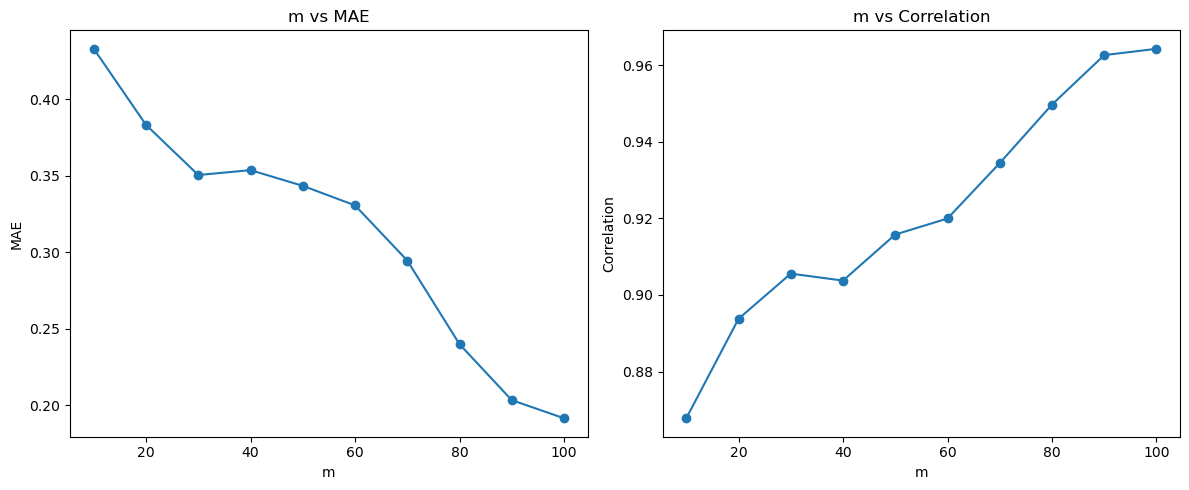

In [25]:
import matplotlib.pyplot as plt

m_list.pop()
corr_list.pop()
mae_list.pop()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(m_list, mae_list, marker='o')
axs[0].set_title("m vs MAE")
axs[0].set_xlabel("m")
axs[0].set_ylabel("MAE")


axs[1].plot(m_list, corr_list, marker='o')
axs[1].set_title("m vs Correlation")
axs[1].set_xlabel("m")
axs[1].set_ylabel("Correlation")

plt.tight_layout()
plt.show()

### Defining a function to find the optimal subset of stocks to form a portfolio that would best replicate the Index fund using the **Big M** method.

In [29]:
import os

TIME_LIMIT = 3600

def mip_portfolio(train_csv, test_csv, m, M=1e6, time_limit=TIME_LIMIT, results_file_prefix="portfolio_results"):
    results_file = f"{results_file_prefix}_m{m}.csv"
    

    if os.path.exists(results_file):
        print(f"Results file for m={m} found! Loading saved results...")
        stock_weights = pd.read_csv(results_file, index_col=0).to_dict()['Weight']
        print(f"Loaded stock weights for m={m}:", stock_weights)
        return stock_weights
    

    df = pd.read_csv(train_csv)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df.sort_index(inplace=True)
    

    returns_df = (df / df.shift(1) - 1) * 100
    returns_df = returns_df[1:]
    returns_df.fillna(0, inplace=True)

    index_returns = returns_df.iloc[:, 0]
    stock_returns = returns_df.iloc[:, 1:]

    n = len(stock_returns.columns)
    if m > n:
        m = n

    r = stock_returns.to_numpy()
    q = index_returns.to_numpy()
    T = len(q)

    model = gp.Model()
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = time_limit

    w = model.addMVar(n, lb=0, ub=1)
    y = model.addMVar(n, vtype=GRB.BINARY)
    z = model.addMVar(T, lb=0)

    for i in range(n):
        model.addConstr(w[i] <= y[i] * M)

    model.addConstr(gp.quicksum(y[i] for i in range(n)) == m)

    for t in range(T):
        model.addConstr(z[t] >= q[t] - gp.quicksum(w[i] * r[t, i] for i in range(n)))
        model.addConstr(z[t] >= gp.quicksum(w[i] * r[t, i] for i in range(n)) - q[t])


    model.addConstr(gp.quicksum(w[i] for i in range(n)) == 1)


    model.setObjective(gp.quicksum(z[t] for t in range(T)), GRB.MINIMIZE)


    model.optimize()


    stock_weights = {col: w.x[i] for i, col in enumerate(stock_returns.columns) if y.x[i] > 0.5}


    pd.DataFrame.from_dict(stock_weights, orient='index', columns=['Weight']).to_csv(results_file)
    print(f"Results saved to {results_file}")
    
    return stock_weights
    print(f"Results saved to {results_file}")
    
    return stock_weights


### Running the function for different values of m.

In [30]:
for m in range(10, 101, 10):
    print(f"Running optimization for m = {m}")
    mip_portfolio("2023data.csv", "2024data.csv", m)

Running optimization for m = 10
Results saved to portfolio_results_m10.csv
Running optimization for m = 20
Results saved to portfolio_results_m20.csv
Running optimization for m = 30
Results saved to portfolio_results_m30.csv
Running optimization for m = 40
Results saved to portfolio_results_m40.csv
Running optimization for m = 50
Results saved to portfolio_results_m50.csv
Running optimization for m = 60
Results saved to portfolio_results_m60.csv
Running optimization for m = 70
Results saved to portfolio_results_m70.csv
Running optimization for m = 80
Results saved to portfolio_results_m80.csv
Running optimization for m = 90
Results saved to portfolio_results_m90.csv
Running optimization for m = 100
Results saved to portfolio_results_m100.csv


### Importing the CSV files and calculting MAEs and Correlations b/w the Index fund and small portfolios for different m values and plotting them.

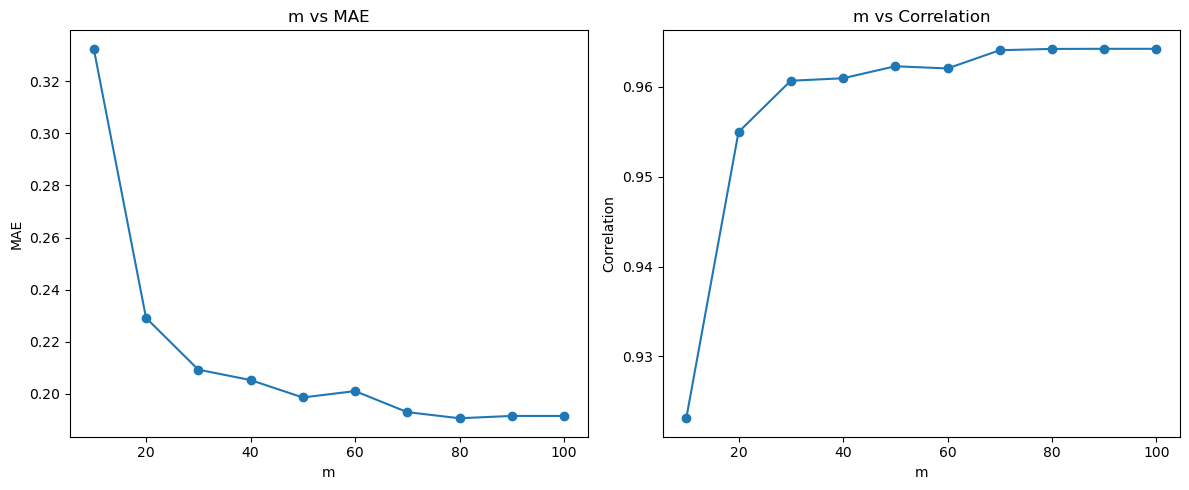

In [15]:
m_values = list(range(10, 101, 10))
mae_list2 = []
corr_list2 = []

for m in m_values:
    results_file = f"portfolio_results_m{m}.csv"
    stock_weights = pd.read_csv(results_file, index_col=0)["Weight"].to_dict()
    
    
    test_df = pd.read_csv("2024data.csv")
    test_df["Date"] = pd.to_datetime(test_df["Date"])
    test_df = test_df.set_index("Date")
    test_df.sort_index(inplace=True)
    
    returns_test = (test_df / test_df.shift(1) - 1) * 100
    returns_test = returns_test[1:]
    returns_test.fillna(returns_test.mean(), inplace=True)
    
    index_returns_test = returns_test.iloc[:, 0]
    stock_returns_test = returns_test[stock_weights.keys()]

    
    r2 = stock_returns_test.to_numpy()
    q2 = index_returns_test.to_numpy()
    weights = np.array(list(stock_weights.values()))
    weighted_r2 = np.dot(r2, weights)
    
    mae = np.mean(np.abs(q2 - weighted_r2))
    mae_list2.append(mae)
    
    
    correlation = np.corrcoef(q2, weighted_r2)[0, 1]
    corr_list2.append(correlation)


fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(m_values, mae_list2, marker='o')
axs[0].set_title("m vs MAE")
axs[0].set_xlabel("m")
axs[0].set_ylabel("MAE")

axs[1].plot(m_values, corr_list2, marker='o')
axs[1].set_title("m vs Correlation")
axs[1].set_xlabel("m")
axs[1].set_ylabel("Correlation")

plt.tight_layout()
plt.show()

### Comparing the results from the 1st method and the 2nd method.

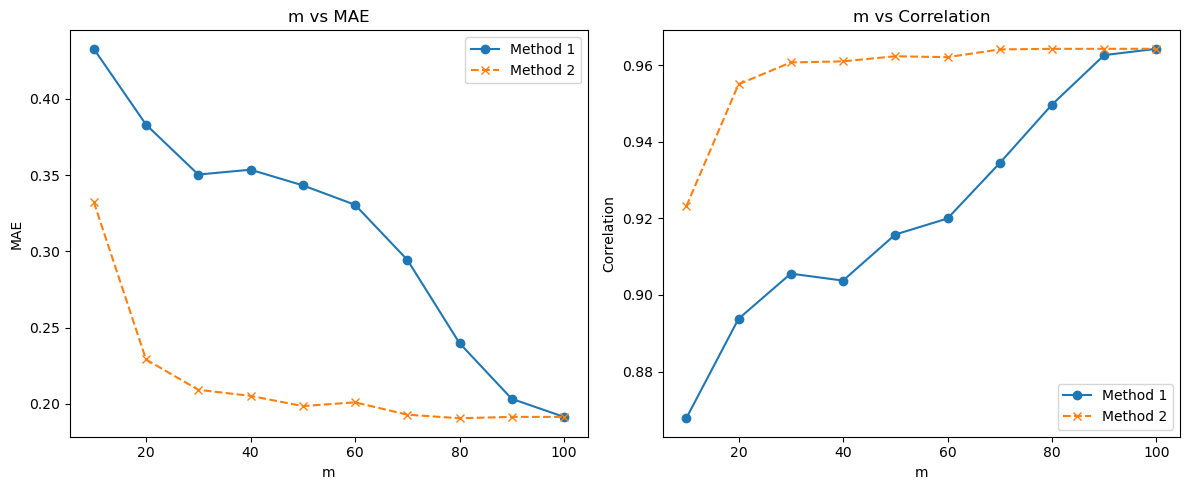

In [26]:
m_values = list(range(10, 101, 10))


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].plot(m_list, mae_list, marker='o', label="Method 1")
axs[0].plot(m_list, mae_list2, marker='x', linestyle='--', label="Method 2")
axs[0].set_title("m vs MAE")
axs[0].set_xlabel("m")
axs[0].set_ylabel("MAE")
axs[0].legend()


axs[1].plot(m_list, corr_list, marker='o', label="Method 1")
axs[1].plot(m_list, corr_list2, marker='x', linestyle='--', label="Method 2")
axs[1].set_title("m vs Correlation")
axs[1].set_xlabel("m")
axs[1].set_ylabel("Correlation")
axs[1].legend()


plt.tight_layout()
plt.show()